Import niezbędnych bibliotek

In [2]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from imblearn.over_sampling import SMOTE
from datetime import date
import time
import urllib.request, json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

Opis wszystkich parametrów można znaleźć pod adresem
https://earthquake.usgs.gov/data/comcat/index.php

In [3]:
base_url = 'https://earthquake.usgs.gov/'

Podczas robienia projektu pojawiły się zmiany na stronie, na której używany był web scraping, więc zostało to zastąpione przez API

In [4]:
# def set_values_for_earthquakes(driver, xpath, value):
#     element = driver.find_element(By.XPATH, xpath)
#     element.clear()
#     element.send_keys(value)

# driver = webdriver.Chrome()
# driver.get(base_url)
# driver.maximize_window()
# time.sleep(1)
# catalog_button = driver.find_element(By.XPATH, '//*[@id="main-content"]/div[2]/div[3]/div/div/div[1]/div/div[1]/div/div[2]/div/a')
# catalog_button.click()
# today = date.today()
# two_years_ago = today.replace(year=today.year-2)
# set_values_for_earthquakes(driver, '//*[@id="minmagnitude"]', '4.5')
# set_values_for_earthquakes(driver, '//*[@id="starttime"]', str(two_years_ago))
# search_button = driver.find_element(By.XPATH, '//*[@id="fdsn-submit"]')
# search_button.click()
# for i in range(5):
#     try:
#         time.sleep(10)
#         download_button = driver.find_element(By.XPATH, '/html/body/usgs-root/div/usgs-list/cdk-virtual-scroll-viewport/div[1]/usgs-download-button/div/button')
#         download_button.click()
#         time.sleep(5)
#         json_button_href = driver.find_element(By.XPATH, '/html/body/div[2]/div[2]/div/mat-dialog-container/usgs-download-options/div[1]/ul/li[2]/a').get_attribute('href')
#         break
#     except Exception:
#         if(i == 4):
#             dataframe = pd.read_csv('tsunami_data.csv')
#             print('No data downloaded - using local data')
#         time.sleep(5)
#         continue

# with urllib.request.urlopen(json_button_href) as url:
#     data_json = json.load(url)

# driver.quit()

Pobranie danych za pomocą API

In [5]:
def get_data_from_api():
    today = date.today()
    two_years_ago = today.replace(year=today.year-2)
    with urllib.request.urlopen(f'{base_url}fdsnws/event/1/query?format=geojson&starttime={str(two_years_ago)}&endtime={str(date.today())}&minmagnitude=4.5') as url:
        data = json.loads(url.read().decode())
    return data

data_json = get_data_from_api()
data_json

{'type': 'FeatureCollection',
 'metadata': {'generated': 1684690479000,
  'url': 'https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&starttime=2021-05-21&endtime=2023-05-21&minmagnitude=4.5',
  'title': 'USGS Earthquakes',
  'status': 200,
  'api': '1.14.0',
  'count': 15789},
 'features': [{'type': 'Feature',
   'properties': {'mag': 5.1,
    'place': 'South Sandwich Islands region',
    'time': 1684625606158,
    'updated': 1684626710040,
    'tz': None,
    'url': 'https://earthquake.usgs.gov/earthquakes/eventpage/us6000kdif',
    'detail': 'https://earthquake.usgs.gov/fdsnws/event/1/query?eventid=us6000kdif&format=geojson',
    'felt': None,
    'cdi': None,
    'mmi': None,
    'alert': None,
    'status': 'reviewed',
    'tsunami': 0,
    'sig': 400,
    'net': 'us',
    'code': '6000kdif',
    'ids': ',us6000kdif,',
    'sources': ',us,',
    'types': ',origin,phase-data,',
    'nst': 105,
    'dmin': 7.128,
    'rms': 0.6,
    'gap': 70,
    'magType': 'mww',
    '

Przekonwertowanie danch z formatu JSON na DataFrame, w celu uzyskania wygodniejszego do pracy formatu

In [6]:
tsunami = []
for i in range(len(data_json['features'])):
    tsunami.append(data_json['features'][i]['properties'])

coordinates = []
for i in range(len(data_json['features'])):
    coordinates.append(data_json['features'][i]['geometry']['coordinates'][:2])

coordinates_df = pd.DataFrame(coordinates, columns=['lon', 'lat'])

dataframe = pd.DataFrame(tsunami)
dataframe = pd.concat([dataframe, coordinates_df], axis=1)
raw_data = dataframe.copy()
dataframe.to_csv('raw_tsunami_data.csv')

,mag,place,time,updated,tz,url,detail,felt,cdi,mmi,...,types,nst,dmin,rms,gap,magType,type,title,lon,lat
0,5.1,South Sandwich Islands region,1684625606158,1684626710040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,NaN,...,",origin,phase-data,",105.0,7.128,0.60,70.0,mww,earthquake,M 5.1 - South Sandwich Islands region,-25.5757,-57.9691
1,5.1,southeast of the Loyalty Islands,1684620527835,1684621589040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,NaN,...,",origin,phase-data,",28.0,3.843,0.77,118.0,mb,earthquake,M 5.1 - southeast of the Loyalty Islands,171.5186,-23.4523
2,4.8,"165 km S of Attu Station, Alaska",1684609206342,1684611617040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,NaN,...,",origin,phase-data,",43.0,1.565,0.74,128.0,mb,earthquake,"M 4.8 - 165 km S of Attu Station, Alaska",172.8340,51.3777
3,5.0,None,1684606061159,1684612504040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,NaN,...,",origin,phase-data,",51.0,3.115,0.61,105.0,mb,earthquake,M 5.0 -,170.8165,-22.7476
4,4.5,"20 km NE of Sama Grande, Peru",1684599936487,1684606210040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,NaN,...,",origin,phase-data,",23.0,0.710,0.86,161.0,mb,earthquake,"M 4.5 - 20 km NE of Sama Grande, Peru",-70.3674,-17.6573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15784,5.0,"25 km SE of Vanimo, Papua New Guinea",1621569136058,1627769271040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,NaN,...,",origin,phase-data,",NaN,0.831,0.72,59.0,mb,earthquake,"M 5.0 - 25 km SE of Vanimo, Papua New Guinea",141.4732,-2.8358
15785,4.5,west of the Galapagos Islands,1621566494860,1627769271040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,NaN,...,",origin,phase-data,",NaN,23.158,0.89,111.0,mb,earthquake,M 4.5 - west of the Galapagos Islands,-97.3796,2.2371
15786,4.9,"74 km NNW of Finschhafen, Papua New Guinea",1621564704103,1627769270040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,1.0,2.0,NaN,...,",dyfi,origin,phase-data,",NaN,3.873,0.77,42.0,mb,earthquake,"M 4.9 - 74 km NNW of Finschhafen, Papua New Gu...",147.5786,-5.9363
15787,5.4,"74 km SE of Honiara, Solomon Islands",1621561056219,1644640753271,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,6.0,8.8,5.571,...,",dyfi,internal-moment-tensor,losspager,moment-...",NaN,0.664,1.04,43.0,mww,earthquake,"M 5.4 - 74 km SE of Honiara, Solomon Islands",160.4458,-9.8891


Wyświetlenie danych, zapoznanie się ze strukturą

In [7]:
pd.set_option('max_colwidth', 15)
display(dataframe)

,mag,place,time,updated,tz,url,detail,felt,cdi,mmi,...,types,nst,dmin,rms,gap,magType,type,title,lon,lat
0,5.1,South Sandw...,1684625606158,1684626710040,None,https://ear...,https://ear...,NaN,NaN,NaN,...,",origin,pha...",105.0,7.128,0.60,70.0,mww,earthquake,M 5.1 - Sou...,-25.5757,-57.9691
1,5.1,southeast o...,1684620527835,1684621589040,None,https://ear...,https://ear...,NaN,NaN,NaN,...,",origin,pha...",28.0,3.843,0.77,118.0,mb,earthquake,M 5.1 - sou...,171.5186,-23.4523
2,4.8,165 km S of...,1684609206342,1684611617040,None,https://ear...,https://ear...,NaN,NaN,NaN,...,",origin,pha...",43.0,1.565,0.74,128.0,mb,earthquake,M 4.8 - 165...,172.8340,51.3777
3,5.0,None,1684606061159,1684612504040,None,https://ear...,https://ear...,NaN,NaN,NaN,...,",origin,pha...",51.0,3.115,0.61,105.0,mb,earthquake,M 5.0 -,170.8165,-22.7476
4,4.5,20 km NE of...,1684599936487,1684606210040,None,https://ear...,https://ear...,NaN,NaN,NaN,...,",origin,pha...",23.0,0.710,0.86,161.0,mb,earthquake,M 4.5 - 20 ...,-70.3674,-17.6573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15784,5.0,25 km SE of...,1621569136058,1627769271040,None,https://ear...,https://ear...,NaN,NaN,NaN,...,",origin,pha...",NaN,0.831,0.72,59.0,mb,earthquake,M 5.0 - 25 ...,141.4732,-2.8358
15785,4.5,west of the...,1621566494860,1627769271040,None,https://ear...,https://ear...,NaN,NaN,NaN,...,",origin,pha...",NaN,23.158,0.89,111.0,mb,earthquake,M 4.5 - wes...,-97.3796,2.2371
15786,4.9,74 km NNW o...,1621564704103,1627769270040,None,https://ear...,https://ear...,1.0,2.0,NaN,...,",dyfi,origi...",NaN,3.873,0.77,42.0,mb,earthquake,M 4.9 - 74 ...,147.5786,-5.9363
15787,5.4,74 km SE of...,1621561056219,1644640753271,None,https://ear...,https://ear...,6.0,8.8,5.571,...,",dyfi,inter...",NaN,0.664,1.04,43.0,mww,earthquake,M 5.4 - 74 ...,160.4458,-9.8891


Opis danych

In [8]:
dataframe.describe()

,mag,time,updated,felt,cdi,mmi,tsunami,sig,nst,dmin,rms,gap,lon,lat
count,15789.000000,1.578900e+04,1.578900e+04,3194.000000,3194.000000,1632.000000,15789.000000,15789.000000,7769.000000,15691.000000,15788.000000,15704.000000,15789.000000,15789.000000
mean,4.796636,1.651653e+12,1.657891e+12,57.736068,3.672073,3.552900,0.012350,360.700361,67.479084,4.936528,0.711774,87.420702,26.879783,-3.704110
std,0.367992,1.808935e+10,1.748287e+10,698.756825,1.808480,2.037914,0.110447,88.478898,47.487937,5.708652,0.221828,40.511609,119.147760,32.110519
min,4.500000,1.621558e+12,1.627769e+12,0.000000,0.000000,0.000000,0.000000,312.000000,6.000000,0.000000,0.060000,8.000000,-179.999700,-69.773900
25%,4.500000,1.635736e+12,1.642280e+12,1.000000,2.200000,2.676000,0.000000,312.000000,33.000000,1.434000,0.550000,56.000000,-70.700600,-24.120300
50%,4.700000,1.650292e+12,1.657403e+12,3.000000,3.400000,3.649000,0.000000,340.000000,55.000000,2.886000,0.690000,82.000000,63.886400,-5.400600
75%,4.900000,1.667294e+12,1.674329e+12,9.000000,4.600000,4.678000,0.000000,369.000000,89.000000,6.718500,0.850000,114.000000,130.235700,21.133500
max,8.200000,1.684626e+12,1.684688e+12,25981.000000,9.100000,9.430000,1.000000,2910.000000,452.000000,50.133000,2.820000,283.000000,179.998100,86.260400


Rozmiar danych

In [9]:
dataframe.shape

(15789, 28)

Ilość pustych wartości

In [10]:
dataframe.isnull().sum()

mag            0
place        669
time           0
updated        0
tz         15789
url            0
detail         0
felt       12595
cdi        12595
mmi        14157
alert      14348
status         0
tsunami        0
sig            0
net            0
code           0
ids            0
sources        0
types          0
nst         8020
dmin          98
rms            1
gap           85
magType        0
type           0
title          0
lon            0
lat            0
dtype: int64

Zdecydowałam, że kolumny, które mają większość wartości pustych zostaną usunięte. Usuwam też kolumny z nieistotnymi atrybutami - url, detail, updated, status, net, code, ids, sources, types, magType, title, nst 
Opis atrybutów można znaleźć na stronie https://earthquake.usgs.gov/data/comcat/index.php

In [11]:
dataframe = dataframe.drop(['nst', 'tz', 'url', 'detail', 'felt', 'cdi', 'mmi', 'alert', 'updated','status', 'net', 'code', 'ids', 'sources', 'types', 'magType', 'title'], axis=1)
dataframe

,mag,place,time,tsunami,sig,dmin,rms,gap,type,lon,lat
0,5.1,South Sandw...,1684625606158,0,400,7.128,0.60,70.0,earthquake,-25.5757,-57.9691
1,5.1,southeast o...,1684620527835,0,400,3.843,0.77,118.0,earthquake,171.5186,-23.4523
2,4.8,165 km S of...,1684609206342,0,354,1.565,0.74,128.0,earthquake,172.8340,51.3777
3,5.0,None,1684606061159,0,385,3.115,0.61,105.0,earthquake,170.8165,-22.7476
4,4.5,20 km NE of...,1684599936487,0,312,0.710,0.86,161.0,earthquake,-70.3674,-17.6573
...,...,...,...,...,...,...,...,...,...,...,...
15784,5.0,25 km SE of...,1621569136058,0,385,0.831,0.72,59.0,earthquake,141.4732,-2.8358
15785,4.5,west of the...,1621566494860,0,312,23.158,0.89,111.0,earthquake,-97.3796,2.2371
15786,4.9,74 km NNW o...,1621564704103,0,370,3.873,0.77,42.0,earthquake,147.5786,-5.9363
15787,5.4,74 km SE of...,1621561056219,0,454,0.664,1.04,43.0,earthquake,160.4458,-9.8891


Usunięcie pustych wartości

In [12]:
dataframe = dataframe.dropna()
dataframe = dataframe.reset_index(drop=True)

Kolumna 'type' wygląda jakby zawierała tylko jedną wartość, więc należy zrobić sprawdzenie wartości unikalnych

In [13]:
dataframe['type'].unique()

array(['earthquake'], dtype=object)

W kolumnie 'type' jest tylko jedna wartość, więc należy ją usunąć

In [14]:
dataframe = dataframe.drop(['type'], axis=1)

Kolumna 'place' zawiera dużo zbędnych informacji, więc wyciągam z niej to co mnie interesuje, czyli nazwę miejsca zdarzenia

In [15]:
country = []
for i in range(len(dataframe['place'])):
    country.append(dataframe['place'][i].split(', ')[-1])
dataframe['place_country'] = country

Usunięcie kolumny 'place', bo została dodana kolumna 'place_country', która zawiera potrzebne informacje

In [16]:
dataframe = dataframe.drop(['place'], axis=1)

Sprawdzenie unikatowych wartości dotyczących miejsca - ma to na celu poprawienie wartości bardzo do siebie podobnych, uogólnienie oraz usunięcie błędów w pisowni

In [17]:
dataframe['place_country'].unique()

array(['South Sandwich Islands region',
       'southeast of the Loyalty Islands', 'Alaska', 'Peru',
       'South Indian Ocean', 'Japan', 'Argentina', 'New Caledonia',
       'Vanuatu', 'Greece', 'Philippines', 'Chile', 'Indonesia',
       'Molucca Sea', 'Somalia', 'Tonga', 'Fiji',
       'south of the Fiji Islands', 'central East Pacific Rise', 'Russia',
       'Dominican Republic', 'Carlsberg Ridge', 'Guatemala',
       'Svalbard and Jan Mayen', 'Papua New Guinea', 'Myanmar',
       'Kazakhstan', 'North Atlantic Ocean', 'Mexico', 'Fiji region',
       'Eritrea', 'Greenland Sea', 'Colombia', 'Japan region',
       'Banda Sea', 'Reykjanes Ridge', 'Micronesia', 'Mid-Indian Ridge',
       'Ecuador', 'southern East Pacific Rise', 'Iran', 'Tajikistan',
       'New Zealand', 'Mariana Islands region', 'south of Tonga',
       'Australia', 'Taiwan', 'Guam', 'CA', 'West Chile Rise', 'Turkey',
       'Lake Almanor Earthquake', 'India', 'China',
       'central Mid-Atlantic Ridge', 'Vanuatu reg

Zapisanie danych dotyczących miejsc do pliku txt - pomoże to w analizie

In [18]:
with open('countries.txt', 'w') as f:
    for item in sorted(dataframe['place_country'].unique()):
        f.write("%s\n" % item)

Poprawa wartości

In [19]:
dataframe['place_country'] = dataframe['place_country'].str.replace(' region', '')
dataframe['place_country'] = dataframe['place_country'].str.replace('central ', '')
dataframe['place_country'] = dataframe['place_country'].str.replace('Central ', '')
dataframe['place_country'] = dataframe['place_country'].str.replace('east of ', '')
dataframe['place_country'] = dataframe['place_country'].str.replace('East of the ', '')
dataframe['place_country'] = dataframe['place_country'].str.replace('East ', '')
dataframe['place_country'] = dataframe['place_country'].str.replace('eastern ', '')
dataframe['place_country'] = dataframe['place_country'].str.replace('near the coast of ', '')
dataframe['place_country'] = dataframe['place_country'].str.replace('north of ', '')
dataframe['place_country'] = dataframe['place_country'].str.replace('North ', '')
dataframe['place_country'] = dataframe['place_country'].str.replace('north', '')
dataframe['place_country'] = dataframe['place_country'].str.replace('Northern ', '')
dataframe['place_country'] = dataframe['place_country'].str.replace('norththe ', '')
dataframe['place_country'] = dataframe['place_country'].str.replace('northeast of ', '')
dataframe['place_country'] = dataframe['place_country'].str.replace('northern ', '')
dataframe['place_country'] = dataframe['place_country'].str.replace('off the east coast of ', '')
dataframe['place_country'] = dataframe['place_country'].str.replace('off the south coast of ', '')
dataframe['place_country'] = dataframe['place_country'].str.replace('off the west coast of ', '')
dataframe['place_country'] = dataframe['place_country'].str.replace('off the coast of ', '')
dataframe['place_country'] = dataframe['place_country'].str.replace('Off the coast of ', '')
dataframe['place_country'] = dataframe['place_country'].str.replace('south of ', '')
dataframe['place_country'] = dataframe['place_country'].str.replace('southeast ', '')
dataframe['place_country'] = dataframe['place_country'].str.replace('southern ', '')
dataframe['place_country'] = dataframe['place_country'].str.replace('Southern ', '')
dataframe['place_country'] = dataframe['place_country'].str.replace('southwest of ', '')
dataframe['place_country'] = dataframe['place_country'].str.replace('South ', '')
dataframe['place_country'] = dataframe['place_country'].str.replace('south ', '')
dataframe['place_country'] = dataframe['place_country'].str.replace('Strait of ', '')
dataframe['place_country'] = dataframe['place_country'].str.replace('west of ', '')
dataframe['place_country'] = dataframe['place_country'].str.replace('western ', '')
dataframe['place_country'] = dataframe['place_country'].str.replace('Near the coast of ', '')
dataframe['place_country'] = dataframe['place_country'].str.replace('near the north coast of ', '')
dataframe['place_country'] = dataframe['place_country'].str.replace(' earthquake sequence', '')
dataframe['place_country'] = dataframe['place_country'].str.split('-').str[0]

Sprawdzenie, w których miejscach było najwięcej trzęsień ziemi

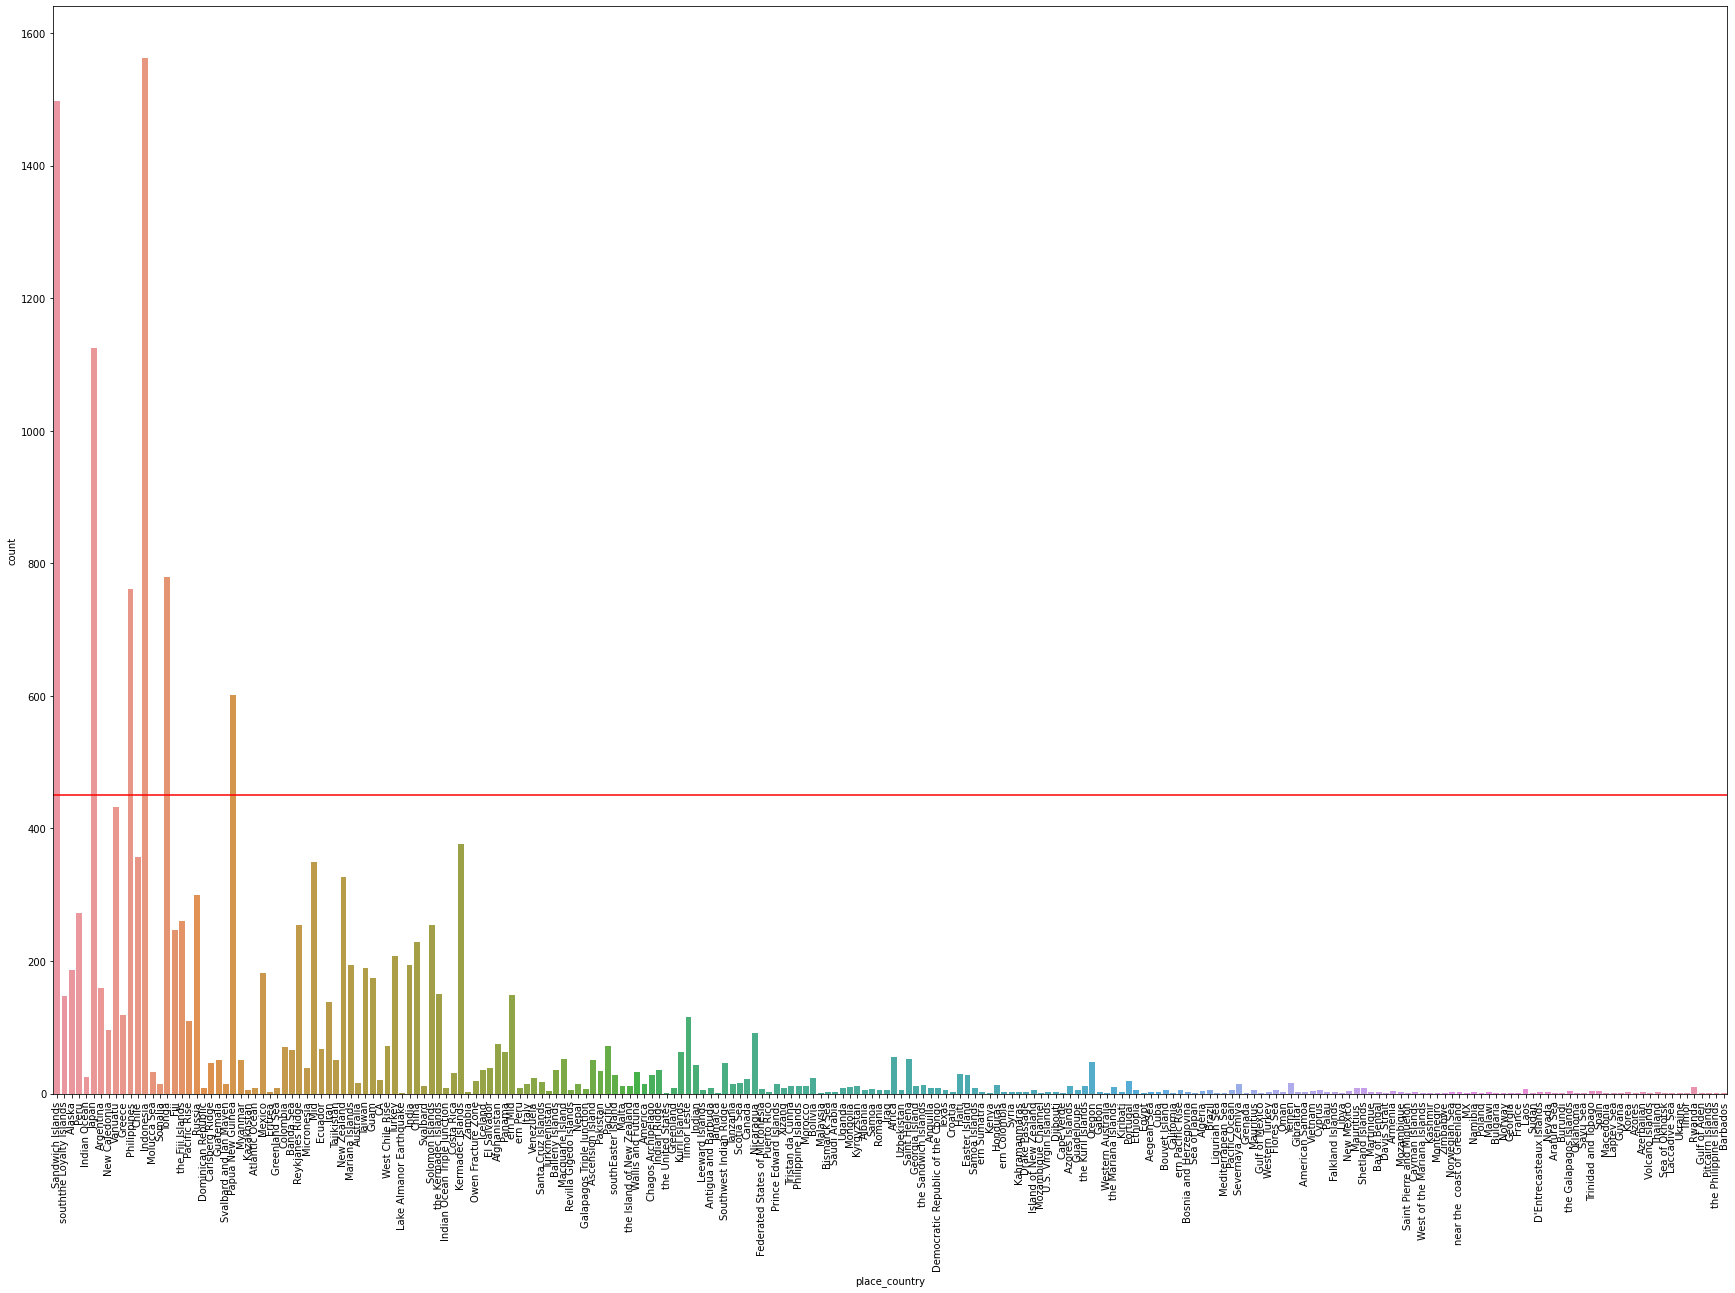

In [20]:
plt.figure(figsize=(30,20))
sns.countplot(x='place_country', data=dataframe)
plt.xticks(rotation=90)
plt.axhline(y=450, color='r', linestyle='-')
plt.show()

Powyższy wykres jest bardzo nieczytelny, ale pozwala nam określić, którym wartościom się dokładniej przyjrzeć - powyżej 450 wystąpień, zaznaczone czerwoną linią

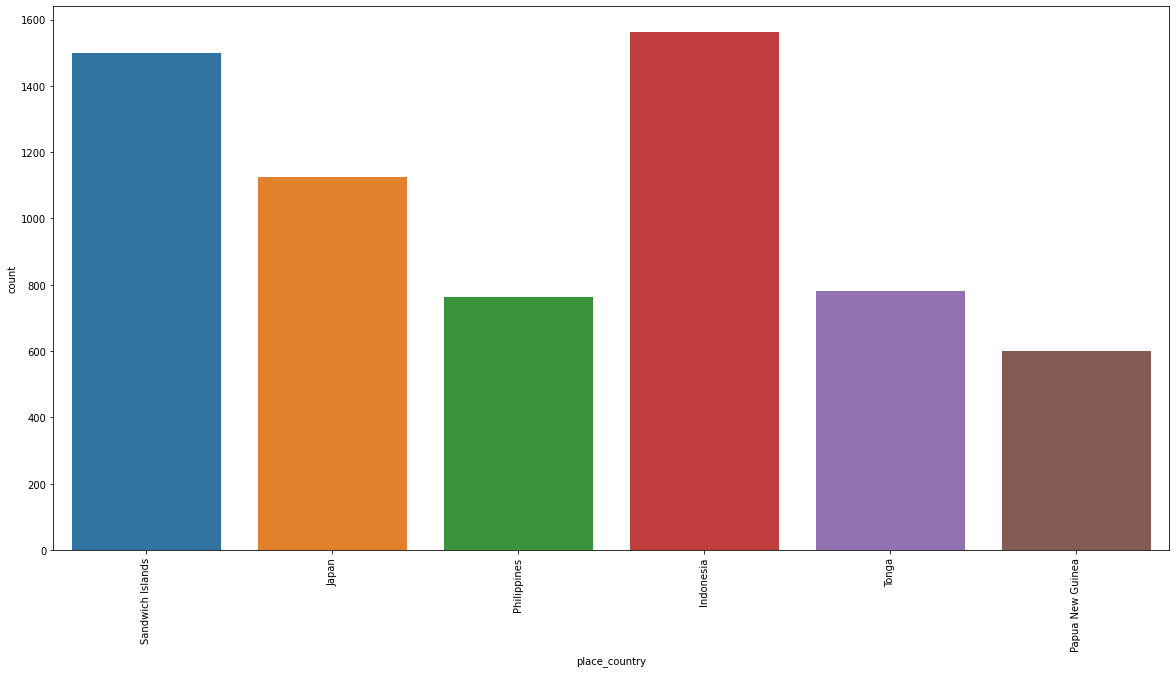

In [21]:
plt.figure(figsize=(20,10))
sns.countplot(x='place_country', data=dataframe[dataframe['place_country'].isin(dataframe['place_country'].value_counts()[dataframe['place_country'].value_counts() > 450].index)])
plt.xticks(rotation=90)
plt.show()

Można zauważyć, że Indonezja i Sandwich Island to miejsca zagrożone największą ilością trzęsień ziemi.

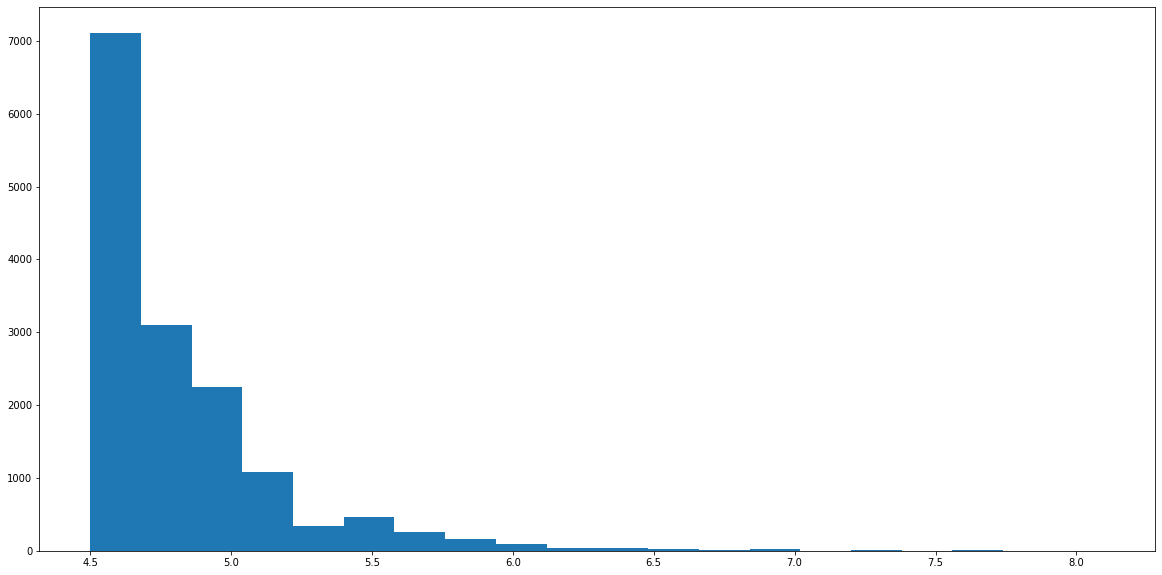

In [22]:
plt.figure(figsize=(20,10))
plt.hist(dataframe['mag'], bins=20)
plt.show()

Transformacja danych kategorycznych na dane liczbowe

In [23]:
import pickle
encoder = LabelEncoder()
dataframe['place_country'] = encoder.fit_transform(dataframe['place_country'])
with open('label_encoder_for_places.pickle', 'wb') as f:
    pickle.dump(encoder, f)

In [24]:
dataframe

,mag,time,tsunami,sig,dmin,rms,gap,lon,lat,place_country
0,5.1,1684625606158,0,400,7.128,0.60,70.0,-25.5757,-57.9691,165
1,5.1,1684620527835,0,400,3.843,0.77,118.0,171.5186,-23.4523,218
2,4.8,1684609206342,0,354,1.565,0.74,128.0,172.8340,51.3777,3
3,4.5,1684599936487,0,312,0.710,0.86,161.0,-70.3674,-17.6573,148
4,4.8,1684599239191,0,354,3.549,0.79,122.0,171.2183,-23.3339,218
...,...,...,...,...,...,...,...,...,...,...
15017,5.0,1621569136058,0,385,0.831,0.72,59.0,141.4732,-2.8358,147
15018,4.5,1621566494860,0,312,23.158,0.89,111.0,-97.3796,2.2371,220
15019,4.9,1621564704103,0,370,3.873,0.77,42.0,147.5786,-5.9363,147
15020,5.4,1621561056219,0,454,0.664,1.04,43.0,160.4458,-9.8891,174


Sprawdzenie czy dane są zbalansowane

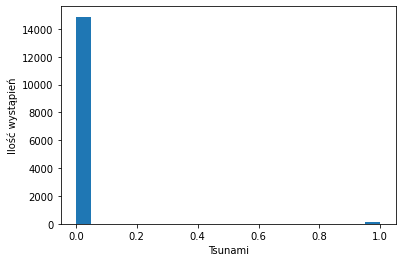

In [25]:
def tsunami_histogram(dataframe):
    fig, ax = plt.subplots()
    ax.hist(dataframe['tsunami'], bins=20)
    ax.set_xlabel('Tsunami')
    ax.set_ylabel('Ilość wystąpień')
    plt.show()

tsunami_histogram(dataframe)

Obecnie zdecydowana większość rekordów jest trzęsieniami, które nie wywołały tsunami. Jeśli wytrenowałabym model na takim zbiorze i sprawdziła accuracy, to przy predykcji, że trzęsienie nie wywoła tsunami dostałabym pewnie około 97%. Wynik ten byłby błędny, bo bazowałby na bardzo zakrzywionych danych.
W celu uzyskania danych odpowiednich do treningu, wykonałam balansowanie danych. 

In [26]:
decision_column = dataframe['tsunami']
attributes = dataframe.drop(['tsunami'], axis=1)
old_dataframe_shape = dataframe.shape
smote = SMOTE()
X, y = smote.fit_resample(attributes, decision_column)
dataframe = pd.concat([pd.DataFrame(X), pd.DataFrame(y)], axis=1)

Zbalansowane dane

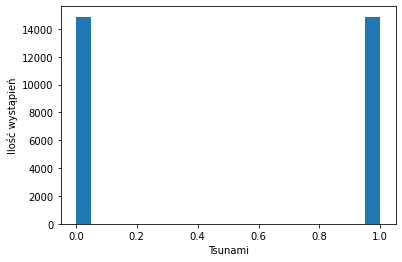

In [27]:
tsunami_histogram(dataframe)

Porównanie rozmiaru danych przed i po balansowaniu

In [28]:
print(f"Shape before balancing: {old_dataframe_shape}")
print(f"Shape after balancing: {dataframe.shape}")

Shape before balancing: (15022, 10)
Shape after balancing: (29764, 10)


In [29]:
dataframe.to_csv('preprocessed_tsunami_data.csv')

Macierz korelacji, która pozwoli na późniejszą manipulację zbiorem przy uczeniu modeli

<AxesSubplot:>

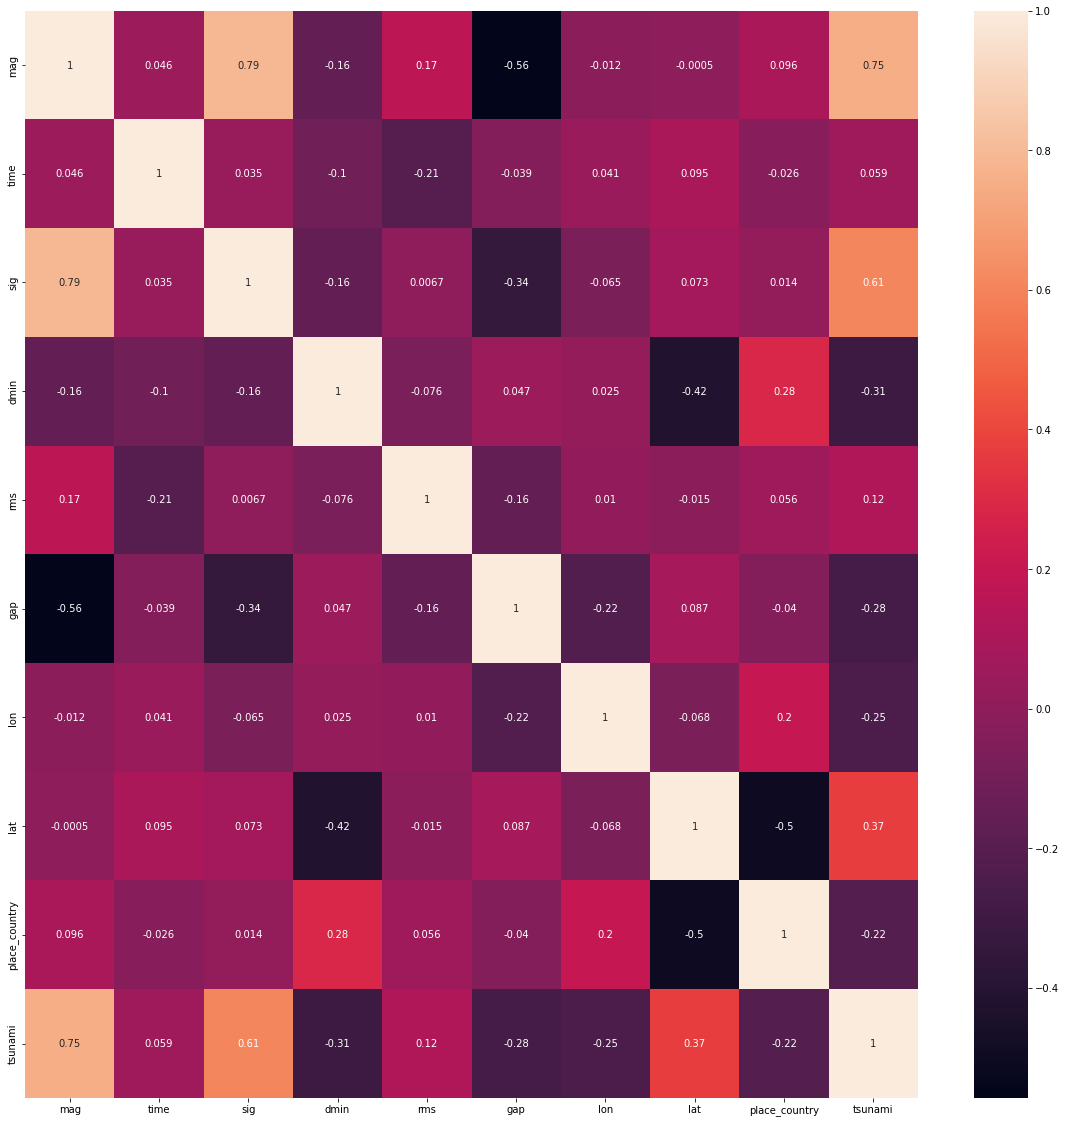

In [30]:
corr = dataframe.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True)

Na nowo przypisuję atrybuty i kolumnę decyzyjną, ponieważ mój zbiór się zmienił.
Dzielenie zbioru na treningowy i testowy.

In [31]:
def split_data(dataframe, *attributes_to_drop):
    decision_column = dataframe['tsunami']
    attributes_to_drop_list = list(attributes_to_drop)
    attributes_to_drop_list.append('tsunami')
    
    attributes = dataframe.drop(attributes_to_drop_list, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(attributes, decision_column, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

In [32]:
def save_results_of_all_models(results, name_of_the_model, accuracy, *removed_attributes):
    removed_attributes_list = list(removed_attributes)
    results[f"{name_of_the_model} without {removed_attributes_list}"] = accuracy
    return results

In [33]:
results = {}

Metoda odpowiedzialna za budowanie trzech modeli - Lasu losowego, KNN oraz Naiwnego Bayesa.

In [34]:
def make_predictors(X_train, X_test, y_train, y_test, *removed_attributes):
    random_forest = RandomForestClassifier()
    random_forest_params = {'n_estimators': [50, 100, 150], 'max_depth': [3,4,5,6]}
    random_forest_grid = GridSearchCV(random_forest, random_forest_params, cv=5)
    random_forest_grid.fit(X_train, y_train)
    random_forest_grid_pred = random_forest_grid.predict(X_test)
    predictions = {'random_forest': random_forest_grid_pred}

    knn = KNeighborsClassifier()
    knn_params = {'n_neighbors': range(2, 10, 2)}
    knn_grid = GridSearchCV(knn, knn_params, cv=5)
    knn_grid.fit(X_train, y_train)
    knn_grid_pred = knn_grid.predict(X_test)
    predictions['knn'] = knn_grid_pred

    naive_bayes = GaussianNB()
    naive_bayes.fit(X_train, y_train)
    naive_bayes_pred = naive_bayes.predict(X_test)
    predictions['naive_bayes'] = naive_bayes_pred

    for y_pred, value in predictions.items():
        accuracy = accuracy_score(y_test, value)
        save_results_of_all_models(results, y_pred, accuracy, *removed_attributes)
        print(y_pred)        
        print('Accuracy: ', accuracy)
    

Poniższa metoda ułatwi czytelność późniejszych kroków

In [35]:
def split_data_train_models_and_show_results(dataframe, *attributes_to_drop):
    X_train, X_test, y_train, y_test = split_data(dataframe, *attributes_to_drop)
    make_predictors(X_train, X_test, y_train, y_test, *attributes_to_drop)

Zbudowanie modeli na podstawowym zbiorze

In [36]:
split_data_train_models_and_show_results(dataframe)

random_forest
Accuracy:  0.9821938518394087
knn
Accuracy:  0.6558037964051738
naive_bayes
Accuracy:  0.5234335629094574


Sprawdzenie wyników predykcji na zbiorze bez kolumny 'gap' - niskie wyniki korelacji

In [37]:
split_data_train_models_and_show_results(dataframe, 'gap')

random_forest
Accuracy:  0.9818578867797749
knn
Accuracy:  0.6558037964051738
naive_bayes
Accuracy:  0.5234335629094574


Sprawdzenie wyników predykcji na zbiorze bez czasu trzęsienia ziemi - niskie wyniki korelacji

In [38]:
split_data_train_models_and_show_results(dataframe, 'time')

random_forest
Accuracy:  0.9815219217201411
knn
Accuracy:  0.9924407861582395
naive_bayes
Accuracy:  0.9314631278347052


Widoczny jest wyraźny pozytywyny skok wyników dla zbioru bez atrybutu "time"

Ze względu na wyniki modeli na usuniętych wartościach 'gap' i 'time', przetestuję usunięcie obu kolumn jednocześnie

In [39]:
split_data_train_models_and_show_results(dataframe, 'gap', 'time')

random_forest
Accuracy:  0.9823618343692256
knn
Accuracy:  0.9879052578531833
naive_bayes
Accuracy:  0.9405341844448177


Usunięcie obu kolumn generuje bardzo dobre wyniki modeli, ale przetestuję też standaryzację zmiennych

Sprawdzenie algorytmów po standaryzacji danych

In [40]:
attributes = dataframe.drop(['gap', 'time', 'tsunami'], axis=1)
decision_column = dataframe['tsunami']

scaler = StandardScaler()
attributes = scaler.fit_transform(attributes)

X_train, X_test, y_train, y_test = train_test_split(attributes, decision_column, test_size=0.2, random_state=42)

make_predictors(X_train, X_test, y_train, y_test)

random_forest
Accuracy:  0.9811859566605073
knn
Accuracy:  0.9937846463967748
naive_bayes
Accuracy:  0.9405341844448177


Użycie standaryzacji danych na zbiorze z usuniętymi kolumnami 'gap' i 'time' dało najwyższy wynik, a najlepszym klasyfikatorem okazał się być KNN.

Zapisanie wyników do pliku json - przydadzą się one w dashboardzie

In [43]:
import json
with open('results_of_models.json', 'w') as fp:
    json.dump(results, fp)